In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Print Columns in Measurment
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Find the most recent date in the data set.

# SQL engine version
# engine.execute("SELECT MAX(date) FROM Measurement;").fetchall()

#SQL Alchemy query version
latest_date = session.query(func.max(Measurement.date)).first()
print(latest_date)

('2017-08-23',)


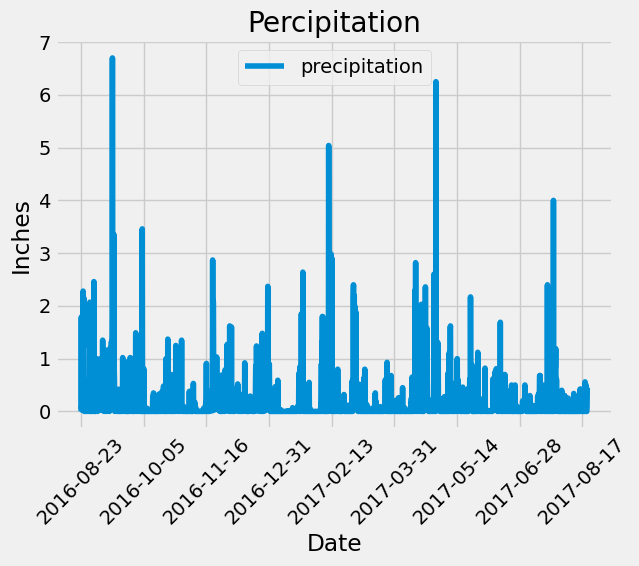

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
# 12 monthes = 1 year, therefore 2016-08-23

# Perform a query to retrieve the data and precipitation scores
year_before_latest = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= "2016-08-23").\
    filter(Measurement.date <= "2017-08-23").all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
measurment_query_df = pd.DataFrame(year_before_latest).set_index("date")
measurment_query_df = measurment_query_df.rename(columns={'prcp':'precipitation'})

# Sort the dataframe by date
measurment_query_df=measurment_query_df.sort_values(by='date').dropna()

# Use Pandas Plotting with Matplotlib to plot the data
measurment_query_df.plot(rot=45)
plt.title("Percipitation")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
measurment_query_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Print Columns in Station
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station.id).count()
print(total_stations)

9


In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# USC00519281 is the most active station
most_active = 'USC00519281'
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == most_active).all()

[(54.0, 85.0, 71.66378066378067)]

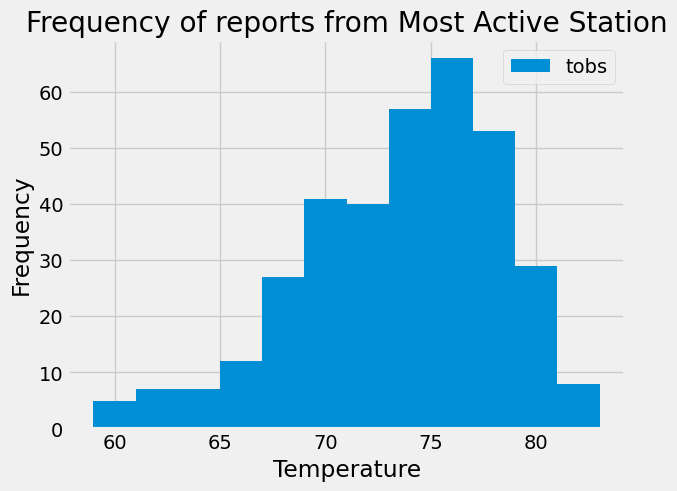

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_observations = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= "2016-08-23").\
    filter(Measurement.date <= "2017-08-23").\
    filter(Measurement.station == most_active).all()

# convert to dataframe
temp_hist_df = pd.DataFrame(temp_observations)

# historgram 
temp_hist_df.plot.hist(bins=12)
plt.title("Frequency of reports from Most Active Station")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

# Close Session

In [19]:
# Close Session
session.close()

In [ ]:
#POST MORTEM NOTES

# although I followed the instructions in the comments, I personally would have prefered to save the sql tables to local pandas dataframes so that I would only need to
# connect to the SQL database from python once